# Build Kitsap County SFINCS
November 29, 2025

Kitsap County SFINCS model, built with WFLOW discharges, DFM tides-and-water-levels, and a higher resolution (20m) quadtree, in one year segments. This is a test!

### 1. Data Load
Here, discharge, water level, DEM, and shape files will be loaded. A summary plot will be made. Discharge data were refined in another file (2025-11-25-wflow-demo.py). 

In [1]:
import xarray as xr
import xugrid as xu
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import utm
from cht_sfincs import SFINCS
from cht_bathymetry import BathymetryDatabase
from pyproj import CRS
import os
from hydromt_sfincs import SfincsModel
import shutil
import requests
import pandas as pd
import matplotlib
import glob

In [3]:
default_color_wheel = plt.rcParams['axes.prop_cycle'].by_key()['color']

lon_min = -123.1
lon_max = -122.4
lat_min = 47.3
lat_max = 48.0 

x_min, y_min, _, __ = utm.from_latlon(lat_min, lon_min)
x_max, y_max, _, __ = utm.from_latlon(lat_max, lon_max)

#### DEM & LULC

In [4]:
dem_file = "/home/cassandra/Data/kitsap_coned_dem_clipped_1m.tif"

dem_file_lowres = "/home/cassandra/Data/kitsap_coned_dem_clipped_10m.tif"
dem = xr.open_dataset(dem_file_lowres)

man_file = "/home/cassandra/Kitsap/kitsap_manning.tif"

#### Shape Files

In [5]:
shapefiles = {'Include Area'      : "/home/cassandra/Kitsap/kitsap_boundary_extended.geojson",
              'Coastal Refinement': "/home/cassandra/Kitsap/kitsap_coastal_area.geojson",
              'Land Boundary'     : "/home/cassandra/Kitsap/Kitsap_land_boundary_regions.geojson",
              'Water Boundary'    : "/home/cassandra/Kitsap/Kitsap_water_boundary_regions.geojson"}

##### Test Plot

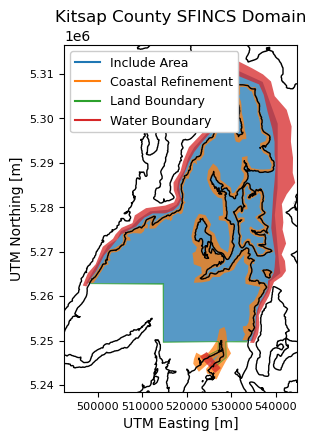

In [6]:
fig, ax = plt.subplots(figsize=(3,5))
for i, name in enumerate(list(shapefiles)):
    gdf = gpd.read_file(shapefiles[name])
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')
    gdf.plot(ax=ax, alpha=0.75, color=default_color_wheel[i], figsize=fig.get_size_inches())
    ax.plot([np.nan, np.nan], color=default_color_wheel[i], label=name)
plt.legend(framealpha=1, fontsize=9, ncol=1, loc=2)
plt.contour(dem.x[::10], dem.y[::10], dem.band_data[0][::10,::10], [0], colors='black', linewidths=1)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Kitsap County SFINCS Domain")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

#### Discharge

In [7]:
da = xr.open_dataset('/media/cassandra/Expansion/Data4Cassandra/discharge_model/kitsap/sfincs_input_discharge.nc')

In [8]:
px, py = da.x.values, da.y.values

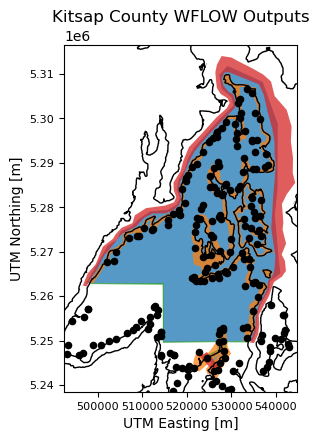

In [9]:
fig, ax = plt.subplots(figsize=(3,5))
for i, name in enumerate(list(shapefiles)):
    gdf = gpd.read_file(shapefiles[name])
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')
    gdf.plot(ax=ax, alpha=0.75, color=default_color_wheel[i], figsize=fig.get_size_inches())
    ax.plot([np.nan, np.nan], color=default_color_wheel[i], label=name)
plt.scatter(px, py, color='black', s = 20)
plt.contour(dem.x[::10], dem.y[::10], dem.band_data[0][::10,::10], [0], colors='black', linewidths=1)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Kitsap County WFLOW Outputs")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

#### Water Levels

In [10]:
wl = xr.open_dataset('/media/cassandra/Expansion/Regional_ERA5_WlWaves_Kitsap_reduced.nc')
wx, wy = wl.x.values, wl.y.values

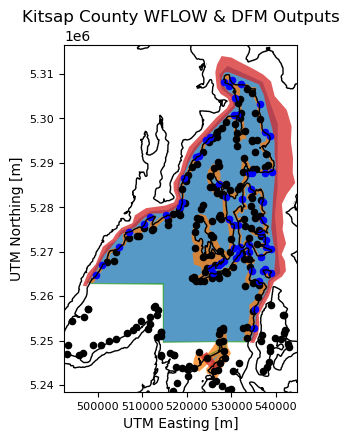

In [11]:
fig, ax = plt.subplots(figsize=(3,5))
for i, name in enumerate(list(shapefiles)):
    gdf = gpd.read_file(shapefiles[name])
    gdf = gdf.set_crs('EPSG:4326').to_crs('EPSG:32610')
    gdf.plot(ax=ax, alpha=0.75, color=default_color_wheel[i], figsize=fig.get_size_inches())
    ax.plot([np.nan, np.nan], color=default_color_wheel[i], label=name)
plt.scatter(px, py, color='black', s = 20)
plt.scatter(wx, wy, color='blue', s = 20)
plt.contour(dem.x[::10], dem.y[::10], dem.band_data[0][::10,::10], [0], colors='black', linewidths=1)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Kitsap County WFLOW & DFM Outputs")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

### Quadtree Model Build

In [12]:
# Quadtree grid characteristics
dx, dy = 160, 160
mmax = int((x_max - x_min)/dx) + 1
nmax = int((y_max - y_min)/dy) + 1
rotation = 0
crs = CRS("WGS 84 / UTM zone 10N")

coastal_refinement_level = 3

# Load polygons, note lat/lon CRS and convert to UTM
include_polygon          = gpd.read_file(shapefiles['Include Area']).set_crs('EPSG:4326').to_crs('EPSG:32610')
water_boundary_polygons  = gpd.read_file(shapefiles['Land Boundary']).set_crs('EPSG:4326').to_crs('EPSG:32610')
land_boundary_polygons   = gpd.read_file(shapefiles['Water Boundary']).set_crs('EPSG:4326').to_crs('EPSG:32610')
refinement_polygons      = gpd.read_file(shapefiles['Coastal Refinement']).set_crs('EPSG:4326').to_crs('EPSG:32610')

# Add a refinement level -- from 160 --> 20 meters, refinement level 3 (160 --> 80 --> 40 --> 20)
levels = coastal_refinement_level * np.ones(len(refinement_polygons)).astype(int)
refinement_polygons = refinement_polygons.assign(refinement_level = levels)

# Create bathymetry database & set
bdb = BathymetryDatabase()
bdb.add_dataset_from_file("dem", dem_file)
bdb.add_dataset_from_file("man", man_file)
bathymetry_sets = [{"name": "dem"}]
roughness_sets  = [{"name": "man"}]

Path to bathymetry database not set !


In [13]:
# SFINCS quadtree build (no subgrid table)
sf = SFINCS(mode="wt", crs=crs)
sf.grid.build(x_min, y_min, nmax, mmax,  dx, dy, rotation,
              refinement_polygons=refinement_polygons,
              bathymetry_sets=bathymetry_sets,
              bathymetry_database=bdb)
sf.grid.set_bathymetry(bathymetry_sets, bathymetry_database=bdb)
sf.mask.build(include_polygon=include_polygon,
              open_boundary_polygon=water_boundary_polygons,
              outflow_boundary_polygon=land_boundary_polygons)
sf.grid.cut_inactive_cells()
sf.grid.write("/home/cassandra/Kitsap/2025-12/sfincs.nc")

Building mesh ...
Refining ...
Time elapsed : 40.6064977645874 s
Finding neighbors ...
Time elapsed : 0.10958504676818848 s
Setting neighbors left and below ...
Time elapsed : 0.3281981945037842 s
Getting uv points ...
Time elapsed : 0.5846951007843018 s
Making XUGrid ...
Got rid of duplicates in 2.3716 seconds
Made XUGrid in 0.0149 seconds
Removing inactive cells ...
Finding neighbors ...
Time elapsed : 0.12812519073486328 s
Setting neighbors left and below ...
Time elapsed : 0.31482625007629395 s
Getting uv points ...
Time elapsed : 0.5025157928466797 s
Making XUGrid ...
Got rid of duplicates in 1.9349 seconds
Made XUGrid in 0.0140 seconds


#### Important note!

Let it be known that this was the memory usage:

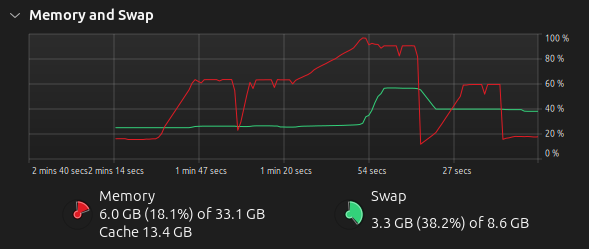

Notably, the bathymetry file is 11.6 GB, yet memory usage is around double that. I initially ran this and it crashed. I tried again, closing all other programs, and it barely ran. 

#### Subgrid Table

In [ ]:
%%capture cap 
# "Magic Command" to squash cell output, becuase subgrid writes a long diagnostic

sf.subgrid.build(bathymetry_sets, roughness_sets, file_name="/home/cassandra/Kitsap/2025-12/sfincs.sbg",
                 roughness_type="manning", 
                 manning_land=0.04, manning_water=0.020, manning_level=1.0,
                 nr_levels=10, nr_subgrid_pixels=20, huthresh=0.01, 
                 zmin=-20.0, zmax=999999.0, bathymetry_database=bdb)

# Save output of this cell to a file
with open("/home/cassandra/Kitsap/2025-12/quadtree_subgrid_build_log.txt", 'w') as file:
    file.write(cap.stdout)